<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Summarize" data-toc-modified-id="Summarize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summarize</a></span></li><li><span><a href="#Simple-Models" data-toc-modified-id="Simple-Models-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Simple Models</a></span></li></ul></li><li><span><a href="#DD-SIMCA-Authentication-Model" data-toc-modified-id="DD-SIMCA-Authentication-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DD-SIMCA Authentication Model</a></span><ul class="toc-item"><li><span><a href="#Can-we-&quot;clean&quot;-the-data?" data-toc-modified-id="Can-we-&quot;clean&quot;-the-data?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Can we "clean" the data?</a></span></li><li><span><a href="#SHAP-Explanations" data-toc-modified-id="SHAP-Explanations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SHAP Explanations</a></span></li><li><span><a href="#Can-we-improve-the-model-with-more-data?" data-toc-modified-id="Can-we-improve-the-model-with-more-data?-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Can we improve the model with more data?</a></span></li></ul></li><li><span><a href="#EllipticManifold-Model" data-toc-modified-id="EllipticManifold-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EllipticManifold Model</a></span><ul class="toc-item"><li><span><a href="#Examine-a-few-models-in-low-dimensions" data-toc-modified-id="Examine-a-few-models-in-low-dimensions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Examine a few models in low dimensions</a></span></li><li><span><a href="#Optimize-an-Isomap-Model" data-toc-modified-id="Optimize-an-Isomap-Model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Optimize an Isomap Model</a></span></li><li><span><a href="#Can-the-non-linear-approach-be-improved-with-more-data?" data-toc-modified-id="Can-the-non-linear-approach-be-improved-with-more-data?-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Can the non-linear approach be improved with more data?</a></span></li></ul></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/PyChemAuth.git
    !cd PyChemAuth; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import PyChemAuth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV

shap.initjs()

Overview
--------
This notebook illustrates the analysis of stable isotope and trace element data for strawberries.  This data was provided by Nives Ogrinc.

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-175-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

json      : 2.0.9
numpy     : 1.21.5
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
imblearn  : 0.9.0
shap      : 0.40.0
pandas    : 1.3.5
watermark : 2.3.0
sklearn   : 0.0
seaborn   : 0.11.2
matplotlib: 3.5.1



# Exploratory Data Analysis

## Load Data

In [4]:
raw_df = pd.read_csv('./data/DB_strawberries.csv')

# No missing values
assert(raw_df.isnull().values.any() == False)

In [5]:
raw_df['Origin'].unique() # This data is already set up for building an authentication model.

array(['Authentic SLO', 'Abroad', 'Test SLO'], dtype=object)

In [6]:
# Not really enough data from countries besides Slovenia to model each of them.
# Instead, just consider an authentication task and use these as part of the test set.
np.unique(raw_df['Country'], return_counts=True)

(array(['Croatia', 'France', 'Greece', 'Italy', 'Serbia', 'Slovenia',
        'Spain'], dtype=object),
 array([  6,   3,   1,  18,   1, 125,   3]))

In [7]:
df_test = raw_df.loc[raw_df['Origin'] == 'Test SLO'].drop(['Sample type', 
                                                 'Harvest year', 
                                                 'Lab code', 
                                                 'Short code',  
                                                 'Country'],
                                               axis=1)
df_train = raw_df.loc[raw_df['Origin'] == 'Authentic SLO'].drop(['Sample type', 
                                                 'Harvest year', 
                                                 'Lab code', 
                                                 'Short code', 
                                                 'Country'],
                                               axis=1)

## Summarize

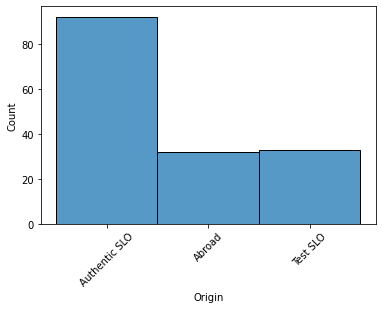

In [8]:
sns.histplot(raw_df, x='Origin')
_ = plt.xticks(rotation=45)

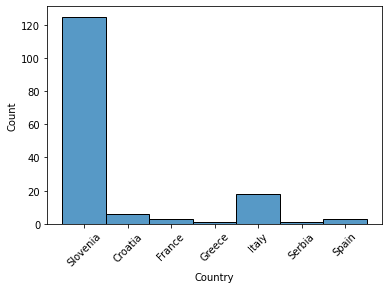

In [9]:
sns.histplot(raw_df, x='Country')
_ = plt.xticks(rotation=45)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def random_forest_importances(X, y, columns, test_size=0.2, n_estimators=100, ax=None):
    """
    Preliminary estimate of feature importance based on random forests.
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=feature%20importance#sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    forest.fit(X_train, y_train) # Tree-based classifiers do not need scaling/normalization

    importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(18,4))
        importance_df = pd.DataFrame(
            columns=['Feature', 'Importance'],
            data=importances,
        )
        plt.xticks(rotation=45)
        _ = sns.barplot(data=importance_df, x='Feature', y='Importance', ax=ax, orient='v')

    ax.set_xlabel('Feature Number')
    ax.set_ylabel('RF Feature Importance')

    return importances

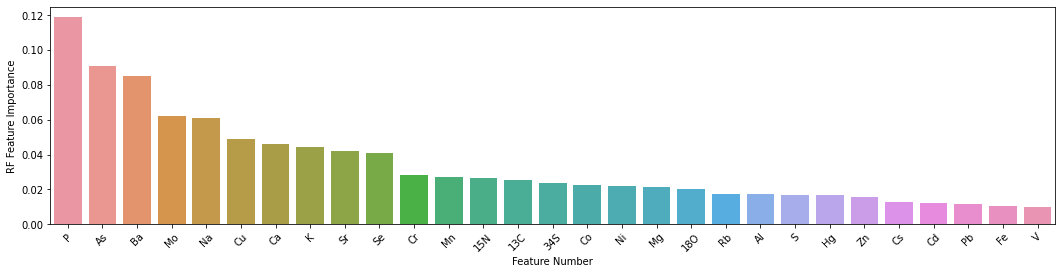

In [11]:
T = raw_df.drop(['Sample type', 'Harvest year', 'Lab code', 'Short code', 'Country'], axis=1)
relabeled = T['Origin'].apply(lambda x: x if 'SLO' not in x else 'SLO')
T['Origin'] = relabeled

X_ = T.drop(['Origin'], axis=1)
y_ = T['Origin'].values

importances = random_forest_importances(
    X=X_.values,
    y=y_,
    columns=X_.columns
)

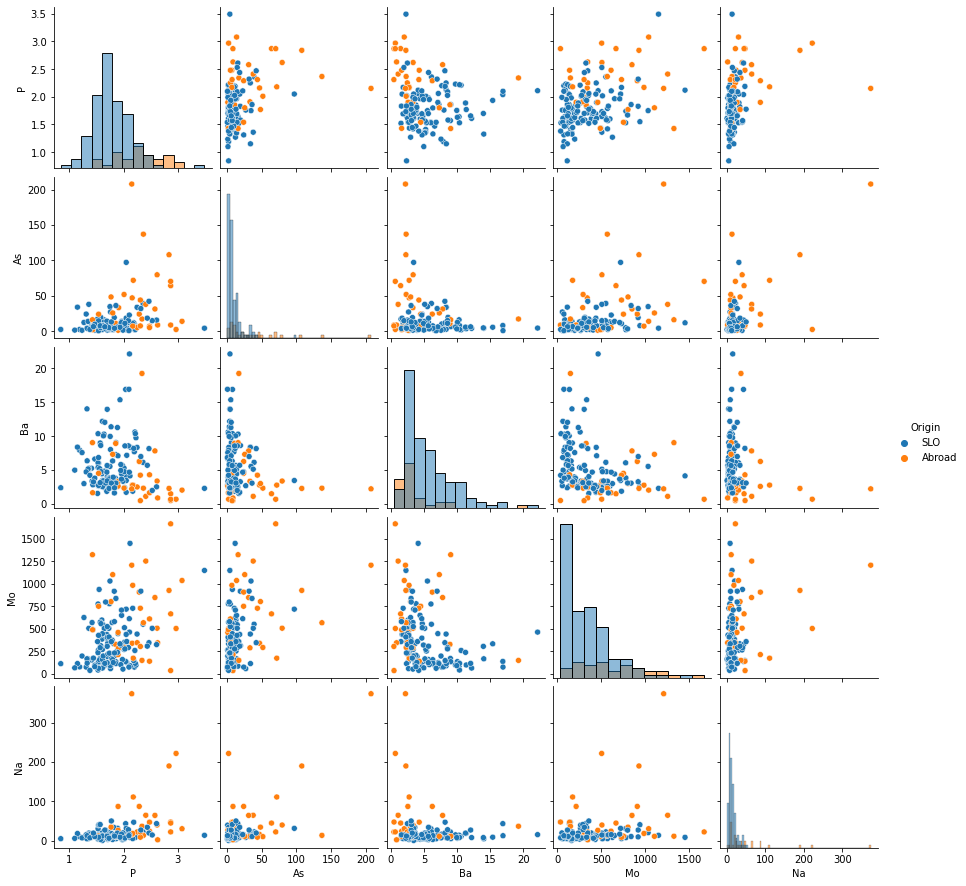

In [12]:
# Some pairwise separation, but also plenty of overlap.  This might be a bit tricky.
sns.pairplot(T, 
             vars=[x_[0] for x_ in importances[:5]],
             diag_kind='hist', 
             hue='Origin')

## Simple Models

Text(0.5, 1.0, 'LDA')

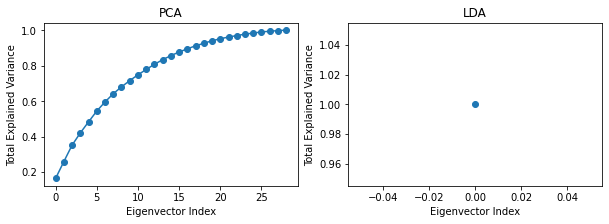

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler

lda = LDA(solver='svd', shrinkage=None, n_components=1)
pca = PCA(whiten=False, random_state=0)

ss = StandardScaler()
X_scaled = ss.fit_transform(T.drop(['Origin'], axis=1).values)

lda.fit(X_scaled, T['Origin'].values)
pca.fit(X_scaled)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = axes.flatten()

ax[0].plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax[0].set_ylabel('Total Explained Variance')
ax[0].set_xlabel('Eigenvector Index')
ax[0].set_title('PCA')

ax[1].plot(np.cumsum(lda.explained_variance_ratio_), '-o')
ax[1].set_ylabel('Total Explained Variance')
ax[1].set_xlabel('Eigenvector Index')
ax[1].set_title('LDA')

In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


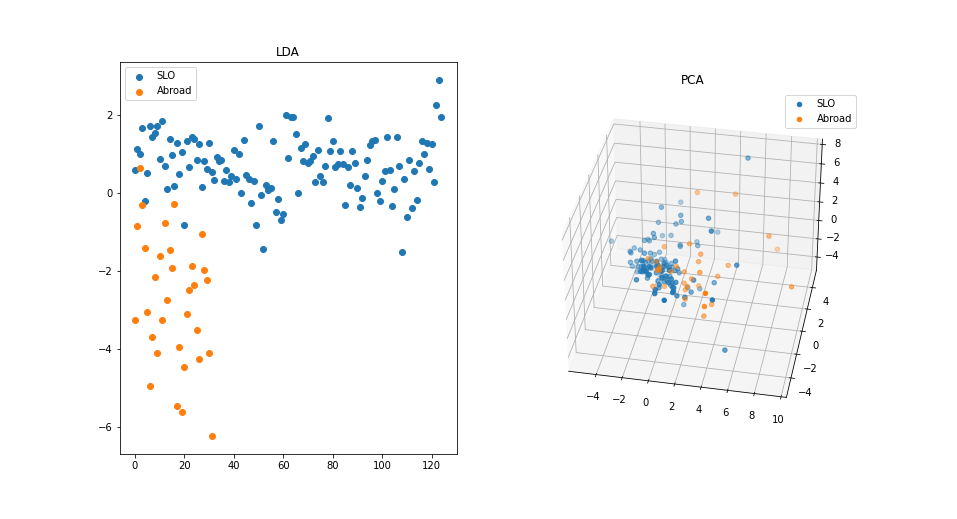

In [15]:
# LDA (supervised) separates well in a few dimensions, PCA (unsupervised) does not

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

X_new_lda = lda.transform(X_scaled)
X_new_pca = pca.transform(X_scaled)

ax = fig.add_subplot(121)
ax.set_title('LDA')
for origin in ['SLO', 'Abroad']:
    x_ = X_new_lda[T['Origin'].values == origin,:]
    ax.scatter(x=np.arange(len(x_)), y=x_[:,0], label=origin)
plt.legend(loc='best')

ax = fig.add_subplot(122, projection='3d')
ax.set_title('PCA')
for origin in ['SLO', 'Abroad']:
    x_ = X_new_pca[T['Origin'].values == origin,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label=origin)
plt.legend(loc='best')

In [22]:
# LDA seems like it is starting to work, PCA (unsupervised) does not seem to yield anything useful in low
# dimensional space.  A better model will be needed if an unsupervised model is expected to perform well.
# Authentication models are semi-supervised because they are knowingly trained on a single (inler) class,
# so this is intermediate.

# Even though the LDA is looking good, the goal is an authentication model not a discrimination one.

# DD-SIMCA Authentication Model

In [16]:
from PyChemAuth.classifier.simca import SIMCA_Classifier

In [17]:
# It looks like we really have only enough data to characterize the Slovenian strawberries so we will
# only build an authentication model for that class.

targets = df_train.Origin.unique()
targets # This model will train only on the "Authentic SLO" data

array(['Authentic SLO'], dtype=object)

In [18]:
# Now let's optimize a SIMCA model based on its total efficiency (TEFF). Data scaling is handled
# internally via the scale_x hyperparameter so we don't need additional step initially, unless
# you want to add this for some reason.

models = {}

for target in targets:
    pipeline = imblearn.pipeline.Pipeline(steps=[
        # Insert other preprocessing steps here...
        # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=target, 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    param_grid = [{
        # 'smote__k_enn':[1, 2, 3],
        # 'smote__k_smote':[1, 3, 3],
        # 'smote__kind_sel_enn':['all', 'mode'],
        'simca__n_components':np.arange(1, 20, 2),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True]
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.KFold(
            n_splits=5, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(
        df_train.drop(['Origin'], axis=1).values, 
        df_train['Origin'].values
    )
    
    models[target] = gs
    
    print(target, gs.best_params_)

Authentic SLO {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': True, 'simca__style': 'dd-simca'}


<IPython.core.display.Javascript object>


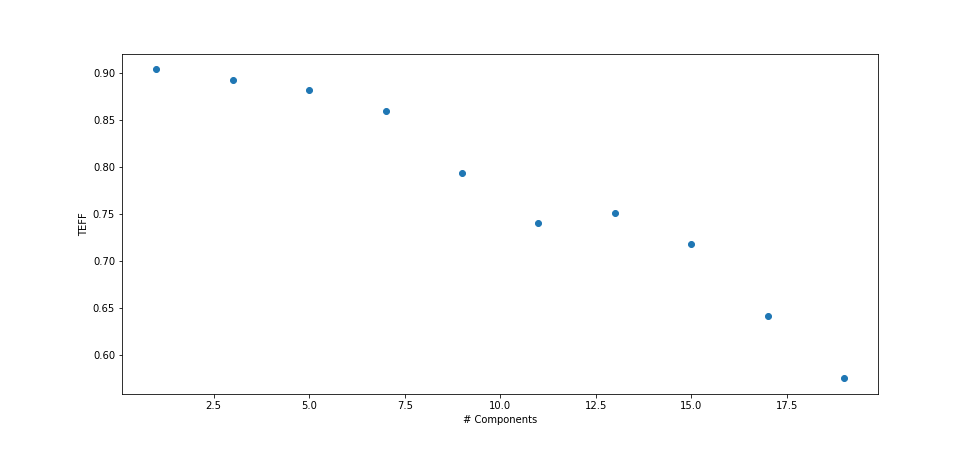

Text(0, 0.5, 'TEFF')

In [19]:
teff = models['Authentic SLO'].cv_results_['mean_test_score']
n = [d['simca__n_components'] for d in models['Authentic SLO'].cv_results_['params']]
plt.figure()
plt.plot(n, teff, 'o')
plt.xlabel('# Components')
plt.ylabel('TEFF')

In [20]:
models['Authentic SLO'].best_score_ # Pretty good results on training

0.9040935672514621

<IPython.core.display.Javascript object>


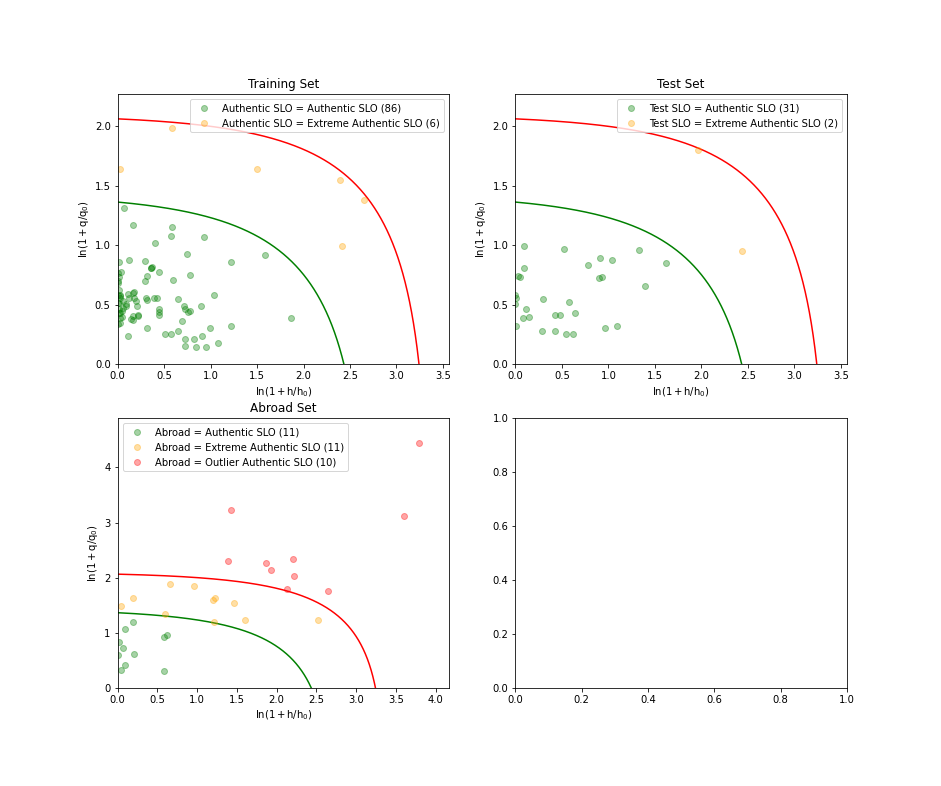

Text(0.5, 1.0, 'Abroad Set')

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

# Training Set
ax = axes[0]
models['Authentic SLO'].best_estimator_.named_steps['simca'].model.visualize(
    df_train.drop(['Origin'], axis=1).values,
    df_train['Origin'].values,
    ax=ax
)
ax.legend(loc='best')
ax.set_title('Training Set')

# Unseen test Set
ax = axes[1]
models['Authentic SLO'].best_estimator_.named_steps['simca'].model.visualize(
    df_test.drop(['Origin'], axis=1).values,
    df_test['Origin'].values,
    ax=ax
)
ax.legend(loc='best')
ax.set_title('Test Set')

# Also consider "outliers"
df_outlier = raw_df.loc[raw_df['Origin'] == 'Abroad'].drop(['Sample type', 
                                                 'Harvest year', 
                                                 'Lab code', 
                                                 'Short code',  
                                                 'Country'],
                                               axis=1)
ax = axes[2]
models['Authentic SLO'].best_estimator_.named_steps['simca'].model.visualize(
    df_outlier.drop(['Origin'], axis=1).values,
    df_outlier['Origin'].values,
    ax=ax
)
ax.legend(loc='best')
ax.set_title('Abroad Set')

# plt.tight_layout()

In [26]:
# Test and train sets seem to perform well, but many samples from abroad are considered "Authentic SLO"
# which is incorrect. This seems consistent with the LDA vs. PCA results.

# From the Abroad set, only 10/32 were identified as outliers. If we take "extreme" predictions as
# "not inliers" then really we have 21/32 ~ 66% accuracy for "Authentic SLO" class membership. DD-SIMCA
# currently uses the alpha level to determine inliers and builds the model around this, so extremes
# are considered to NOT belong to the class.  Therefore, the 66% is a better interpretation.

In [22]:
p_inlier = gs.predict_proba(df_outlier.drop(['Origin'], axis=1).values)[:,0]
np.sum(p_inlier > 0.5) # These are the 11 Abroads predicted to be Authentic SLO

11

## Can we "clean" the data?

In [23]:
# Perhaps we can clean the training set a little more. What if we remove the "extremes" from the training set?

In [24]:
clf = SIMCA_Classifier(n_components=1, alpha=0.05, scale_x=True, style='dd-simca',
                 target_class='Authentic SLO', use='TEFF')

<IPython.core.display.Javascript object>


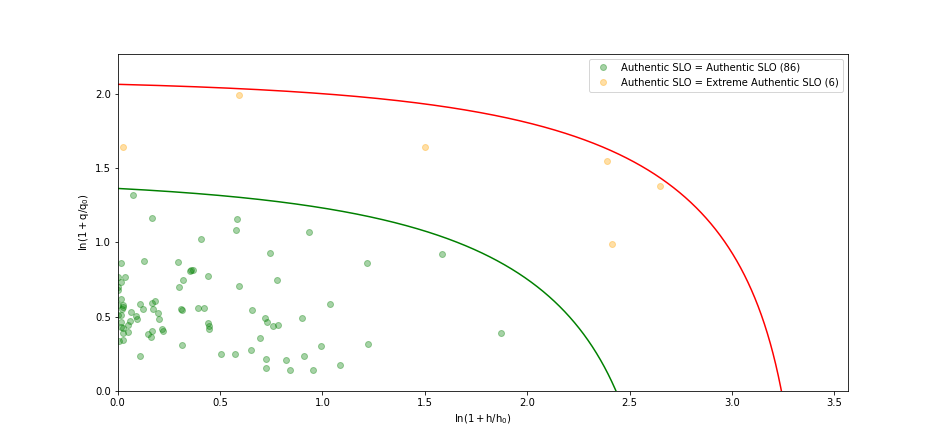

Found 6 extremes and 0 outliers


In [25]:
# Round 1
X_ = df_train.drop(['Origin'], axis=1).values 
y_ = df_train['Origin'].values
clf.fit(X_, y_)
extremes, outliers = clf.model.check_outliers(X_)
clf.model.visualize(X_, y_)
print('Found {} extremes and {} outliers'.format(np.sum(extremes),np.sum(outliers)))

Round 2: Found 6 extremes and 0 outliers
Round 3: Found 6 extremes and 0 outliers
Round 4: Found 3 extremes and 0 outliers
Round 5: Found 1 extremes and 0 outliers
Round 6: Found 1 extremes and 0 outliers
Round 7: Found 2 extremes and 0 outliers
Round 8: Found 0 extremes and 0 outliers


<IPython.core.display.Javascript object>


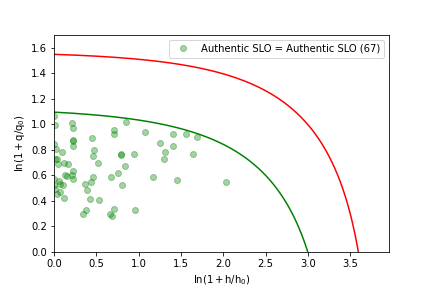

<AxesSubplot:xlabel='${\\rm ln(1 + h/h_0)}$', ylabel='${\\rm ln(1 + q/q_0)}$'>

In [26]:
for round_ in range(2, 10, 1):
    mask = outliers | extremes
    if np.sum(mask) == 0:
        break
    else:
        X_ = X_[~mask]
        y_ = y_[~mask]

        clf.fit(X_, y_)
        extremes, outliers = clf.model.check_outliers(X_)
        print('Round {}: Found {} extremes and {} outliers'.format(round_, np.sum(extremes),np.sum(outliers)))
clf.model.visualize(X_, y_)

<IPython.core.display.Javascript object>


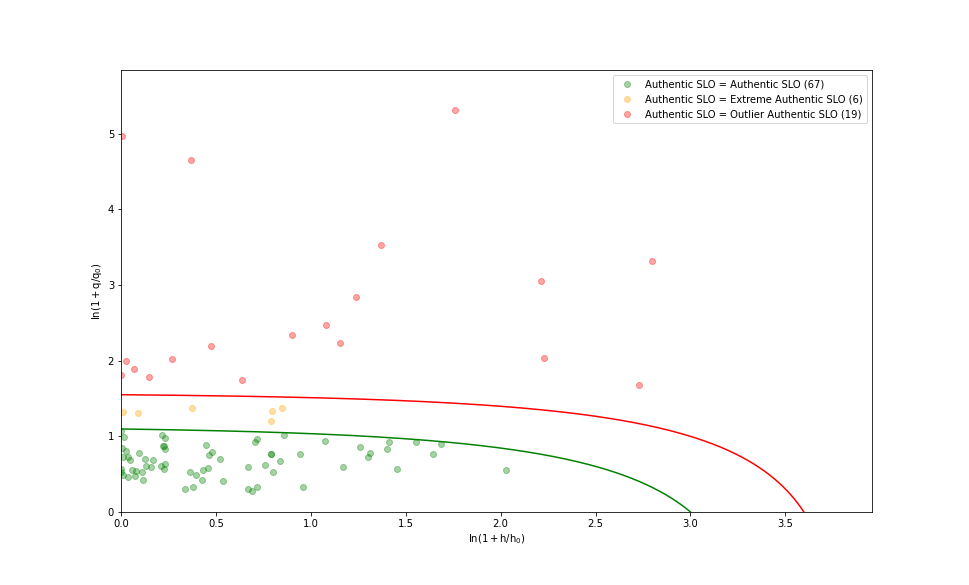

<AxesSubplot:xlabel='${\\rm ln(1 + h/h_0)}$', ylabel='${\\rm ln(1 + q/q_0)}$'>

In [27]:
# This model is now too specific and predicts many authentic samples as being non-authentic
# Changing the number of components to use has no qualitative effect, it seems.

X_ = df_train.drop(['Origin'], axis=1).values 
y_ = df_train['Origin'].values
clf.model.visualize(X_, y_)

## SHAP Explanations

In [28]:
# Let's try to understand the DD-SIMCA model

In [29]:
shap_values_train = {}
shap_values_test = {}
shap_values_abroad = {}
explainer = {}

X_train = df_train.drop(['Origin'], axis=1).values
X_test = df_test.drop(['Origin'], axis=1).values
X_abroad = df_outlier.drop(['Origin'], axis=1).values

for target in targets:
    explain = shap.KernelExplainer(
        model = models[target].predict_proba, 
        data = shap.sample(
            X_train, 
            10, 
            random_state=0 # vs. data = X_train to use full training set
        ), 
    )
    
    explainer[target] = explain
    
    shap_values_train[target] = explain.shap_values(X_train, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )[0] # Just save inlier class results
    
    shap_values_test[target] = explain.shap_values(X_test, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_test.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )[0] # Just save inlier class results
    
    
    shap_values_abroad[target] = explain.shap_values(X_abroad, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_abroad.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )[0] # Just save inlier class results

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
%matplotlib inline

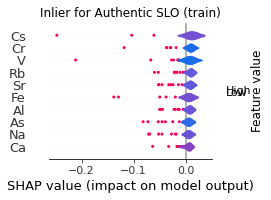

<Figure size 432x288 with 0 Axes>

In [31]:
fig = plt.figure(figsize=(10,6))

for i,target in enumerate(targets):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title('Inlier for {} (train)'.format(target))
    sv = shap_values_train[target]

    shap.summary_plot(
        shap_values=sv,
        features=X_train,
        feature_names=df_train.columns.drop('Origin'),
        plot_type='violin',
        max_display=10
    )
plt.tight_layout()

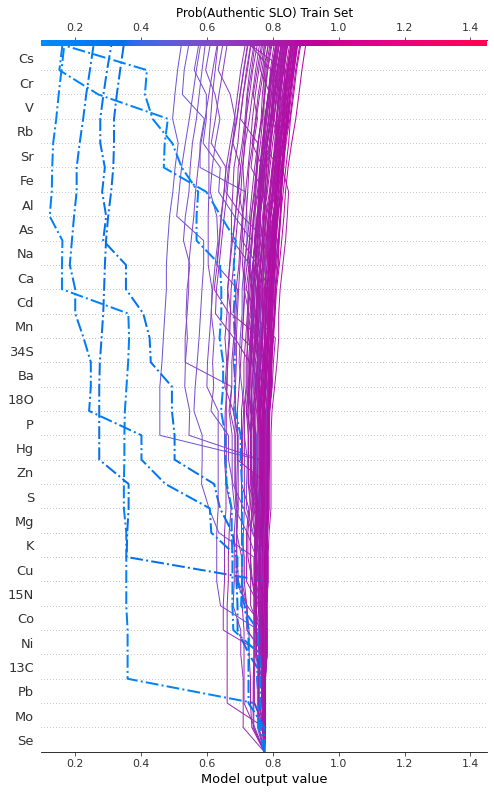

In [32]:
# DD-SIMC implementation considers these "extremes" to NOT be inliers

incorrect = models['Authentic SLO'].predict(X_train) == False

plt.figure()
plt.title('Prob(Authentic SLO) Train Set')
shap.decision_plot(
    explainer['Authentic SLO'].expected_value[0], 
    shap_values_train['Authentic SLO'], 
    feature_names=df_train.columns.drop('Origin').tolist(),
    highlight=incorrect,
    feature_display_range=slice(-1, -51, -1)
)

In [33]:
# Most seem to fall on the same "manifold"/decision path; arguably, there is another set with a final 
# probability ~0.6.  The incorrect predictions seem to have a relatively small set (~5 analytes) that
# dramatically push the probability toward 0 (away from inlier threshold at 0.5).

# This could be because these are "special" samples somehow, or perhaps the training set is not diverse enough
# to understand that these *should* be considered "normal"/regular samples.

In [34]:
# h, q = models['Authentic SLO'].best_estimator_.named_steps['simca'].model.h_q_(X_train)
# x_, y_ = np.log(1+h/np.mean(h)), np.log(1+q/np.mean(q))
# sorted(list(zip(x_[incorrect], y_[incorrect], models['Authentic SLO'].predict_proba(X_train)[incorrect,0])),
#        key=lambda x: x[2])

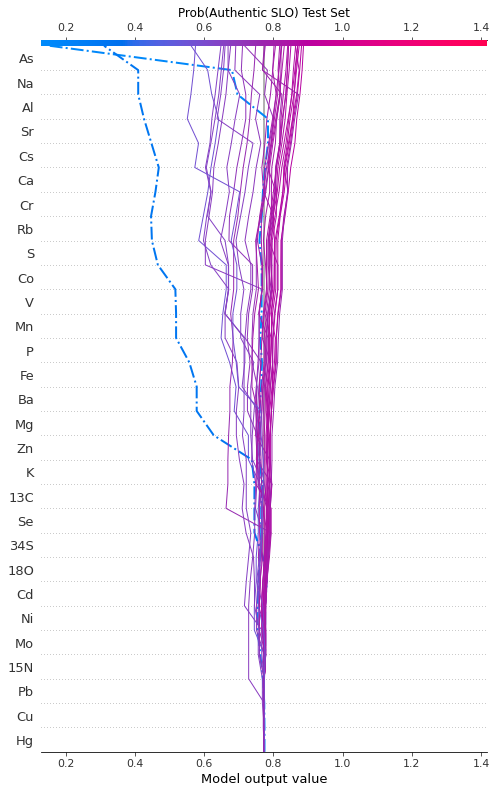

In [35]:
incorrect = models['Authentic SLO'].predict(X_test) == False

plt.figure()
plt.title('Prob(Authentic SLO) Test Set')
shap.decision_plot(
    explainer['Authentic SLO'].expected_value[0], 
    shap_values_test['Authentic SLO'], 
    feature_names=df_test.columns.drop('Origin').tolist(),
    highlight=incorrect,
    feature_display_range=slice(-1, -51, -1)
)

In [36]:
# The test set also contains some samples which are strongly predicted to be inauthentic. If we accept
# that the data provided is accurate, then these data points are showing these model is missing the information
# needed to understand that these are inliers not outliers.

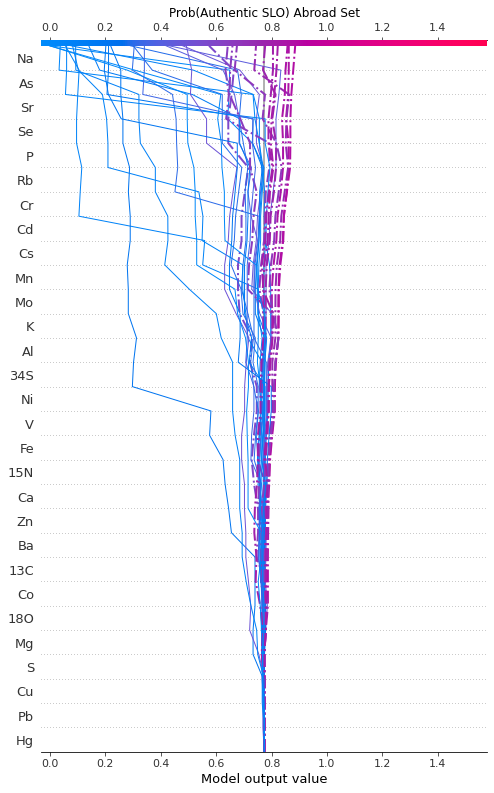

In [37]:
incorrect = models['Authentic SLO'].predict(X_abroad) == True # SHOULD be outliers

plt.figure()
plt.title('Prob(Authentic SLO) Abroad Set')
shap.decision_plot(
    explainer['Authentic SLO'].expected_value[0], 
    shap_values_abroad['Authentic SLO'], 
    feature_names=df_outlier.columns.drop('Origin').tolist(),
    highlight=incorrect,
    feature_display_range=slice(-1, -51, -1)
)

In [38]:
# SHAP values are relative to the average prediction - since this is trained on authentic samples, 
# the points that are abroad (and incorrectly predicted to be Authentic SLO) do not move much relative to
# this (lines are "straight").

# Some samples have a few (again ~5 analytes) that strongly depress the probability (correctly).
# Most are Na-Se, suggesting these might be interesting "fingerprints" for Authentic SLO, by contrast.

# However, there is generally a smooth spectrum of final probabilities, which suggests the model can be
# "fooled" to varying degrees by different "counter-examples".  That suggests the model is not very specific.

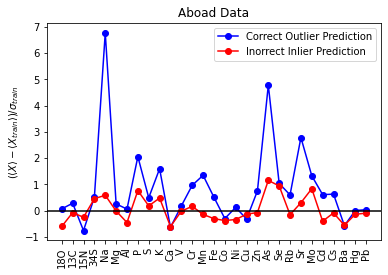

In [39]:
mu = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

plt.plot(
    np.arange(X_abroad.shape[1]),
    (np.mean(X_abroad[~incorrect], axis=0) - mu)/std,
    'o-',
    color='b',
    label='Correct Outlier Prediction'
)
plt.plot(
    np.arange(X_abroad.shape[1]),
    (np.mean(X_abroad[incorrect], axis=0) - mu)/std,
    'o-',
    color='r',
    label='Inorrect Inlier Prediction'
)
plt.xticks(
    ticks=np.arange(df_outlier.shape[1]-1), 
    labels=df_outlier.columns.drop('Origin').tolist(),
    rotation=90
)
plt.axhline(0, color='k')
plt.ylabel(r'$\left( \langle X \rangle - \langle X_{train} \rangle \right)/ \sigma_{train}$')
plt.legend(loc='best')
_ = plt.title('Aboad Data')

In [40]:
# On average, the data that was predicted to be inliers (incorrectly) were closer to the training data than
# those that were correctly predicted to be outliers, with only a few exceptions.

# In practice, we would like a model to be able to detect these baseline differences better. For example,
# 180 in the Abroad dataset predicted to be the Authentic SLO is further away, on average, than those parts
# of the dataset that were correctly predicted to be outliers.  This difference didn't seem to matter, but
# maybe we would like it to?

## Can we improve the model with more data?

In [42]:
import copy
model = copy.deepcopy(models['Authentic SLO'])

In [44]:
X_tot = np.vstack((
    df_train.drop(['Origin'], axis=1).values,
    df_test.drop(['Origin'], axis=1).values,
))
X_tot = sklearn.utils.shuffle(X_tot, random_state=0)

X_out = df_outlier.drop(['Origin'], axis=1).values

performance = []
errors = []
fractions = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for frac in fractions:
    # Shuffle, take fraction of X to work with
    mask = np.array([False]*len(X_tot))
    mask[:int(frac*len(X_tot))] = True
    X = X_tot[mask]
    
    kfold = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    accuracies = []
    for train_index, test_index in kfold.split(X):
        model.fit(X[train_index], ['Authentic SLO']*len(train_index))
        train_pred = model.predict(X[train_index])
        test_pred = model.predict(X[test_index])
        out_pred = model.predict(X_out)
        accuracies.append([
            np.sum(train_pred == True) / len(train_pred),
            np.sum(test_pred == True) / len(test_pred),
            np.sum(out_pred == False) / len(out_pred)
        ])
    performance.append(np.mean(accuracies, axis=0))
    errors.append(np.std(accuracies, axis=0))
performance = np.array(performance)
errors = np.array(errors)

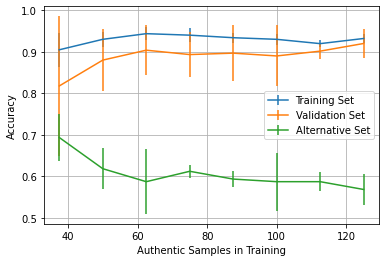

In [45]:
plt.figure()

plt.errorbar(x=fractions*len(X_tot), y=performance[:,0], yerr=errors[:,0], label='Training Set')
plt.errorbar(x=fractions*len(X_tot), y=performance[:,1], yerr=errors[:,1], label='Validation Set')
plt.errorbar(x=fractions*len(X_tot), y=performance[:,2], yerr=errors[:,2], label='Alternative Set')
plt.grid()
plt.xlabel('Authentic Samples in Training')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [ ]:
# Training and validation curves converge, and although unused, the alternative set test results have
# reached a plateau.  This suggests more data will not really improve the model.

# EllipticManifold Model

In [46]:
from PyChemAuth.manifold.elliptic import EllipticManifold

## Examine a few models in low dimensions

In [48]:
model = sklearn.manifold.Isomap #sklearn.manifold.LocallyLinearEmbedding

kwargs = {
    "n_neighbors":10,
    "n_components":2,
}

scaler = PyChemAuth.preprocessing.scaling.CorrectedScaler(
    with_mean=True,
    with_std=True,
    biased=False,
    pareto=False
)
X_train_scaled = scaler.fit_transform(df_train.drop(['Origin'], axis=1).values)
y_train = df_train['Origin'].values

m = EllipticManifold(0.05, model, kwargs)
_ = m.fit(X_train_scaled)

In [49]:
df_outlier = raw_df.loc[raw_df['Origin'] == 'Abroad'].drop(['Sample type', 
                                                 'Harvest year', 
                                                 'Lab code', 
                                                 'Short code',  
                                                 'Country'],
                                               axis=1)
X_outlier_scaled = scaler.transform(df_outlier.drop(['Origin'], axis=1).values)

m.score(X_outlier_scaled, [0]*len(X_outlier_scaled))

1.3422992638974311

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

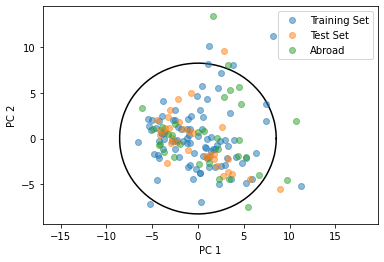

In [50]:
X_test_scaled = scaler.transform(df_test.drop(['Origin'], axis=1).values)

m.visualize([X_train_scaled, X_test_scaled, X_outlier_scaled], 
            ["Training Set", "Test Set", "Abroad"]
           )

## Optimize an Isomap Model

In [52]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaler", PyChemAuth.preprocessing.scaling.CorrectedScaler(
        with_mean=True,
        with_std=True,
        biased=False,
        pareto=False
    )),
    ("mani", EllipticManifold(
        alpha=0.05, 
        dr_model=sklearn.manifold.Isomap,
        kwargs=None)
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
# There are 29 SITE measurements so let's compress to half of that or more (15 dims or less)
param_grid = [{
    'mani__kwargs':[{'n_components':k, 'n_neighbors':n} for k in range(2, 15) for n in [5, 10, 15]],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True,
)

_ = gs.fit(
    df_train.drop(['Origin'], axis=1).values, 
    [1]*len(df_train)
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [53]:
gs.best_params_

{'mani__kwargs': {'n_components': 14, 'n_neighbors': 5}}

Text(0, 0.5, 'Score = -LogLoss')

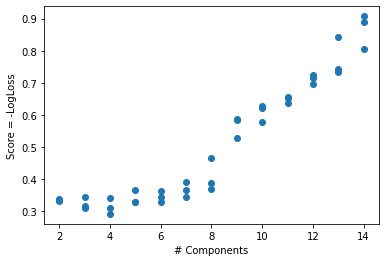

In [54]:
score_ = gs.cv_results_['mean_test_score']
n = [d['mani__kwargs']['n_components'] for d in gs.cv_results_['params']]
plt.figure()
plt.plot(n, score_, 'o')
plt.xlabel('# Components')
plt.ylabel('Score = -LogLoss')

In [55]:
X_train_scaled_ = gs.best_estimator_.named_steps['scaler'].transform(df_train.drop(['Origin'], axis=1).values)
X_test_scaled_ = gs.best_estimator_.named_steps['scaler'].transform(df_test.drop(['Origin'], axis=1).values)
X_outlier_scaled_ = gs.best_estimator_.named_steps['scaler'].transform(df_outlier.drop(['Origin'], axis=1).values)

# Training and test sets should be class 0 (y=1)
acc_train = np.sum(gs.best_estimator_.named_steps['mani'].predict(X_train_scaled_) == 1) / len(X_train_scaled_)
acc_test = np.sum(gs.best_estimator_.named_steps['mani'].predict(X_test_scaled_) == 1) / len(X_test_scaled_)

# Abroad samples should be identified as class 1 (outliers, y=0)
acc_out = np.sum(gs.best_estimator_.named_steps['mani'].predict(X_outlier_scaled_) == 0) / len(X_outlier_scaled_)

In [56]:
acc_train # Reasonable training set accruacy

0.8695652173913043

In [57]:
acc_test # Test set accuracy drops

0.7272727272727273

In [58]:
acc_out 
# However, again, the foreign samples are not easy to detect.  This is much better than ~33%
# achieved with DD-SIMCA, but is still not excellent. 

# This manifold DR uses a non-linear approach which is significantly better than the linear
# DD-SIMCA approach.

0.6875

## Can the non-linear approach be improved with more data?

In [59]:
import copy
model = copy.deepcopy(gs)

X_tot = np.vstack((
    df_train.drop(['Origin'], axis=1).values,
    df_test.drop(['Origin'], axis=1).values,
))
X_tot = sklearn.utils.shuffle(X_tot, random_state=0)

X_out = df_outlier.drop(['Origin'], axis=1).values

performance = []
errors = []
fractions = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
for frac in fractions:
    # Shuffle, take fraction of X to work with
    mask = np.array([False]*len(X_tot))
    mask[:int(frac*len(X_tot))] = True
    X = X_tot[mask]
    
    kfold = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    accuracies = []
    for train_index, test_index in kfold.split(X):
        model.fit(X[train_index], [1]*len(train_index))
        train_pred = model.predict(X[train_index])
        test_pred = model.predict(X[test_index])
        out_pred = model.predict(X_out)
        accuracies.append([
            np.sum(train_pred == 1) / len(train_pred),
            np.sum(test_pred == 1) / len(test_pred),
            np.sum(out_pred == 0) / len(out_pred)
        ])
    performance.append(np.mean(accuracies, axis=0))
    errors.append(np.std(accuracies, axis=0))
performance = np.array(performance)
errors = np.array(errors)

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/hom

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w


27 fits failed out of a total of 195.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../PyChemAuth/manifold/elliptic.py", line 190, in fit
    self.model_.fit(X, y)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_isomap.py", line 304, in fit
    self._fit_transform(X)


/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

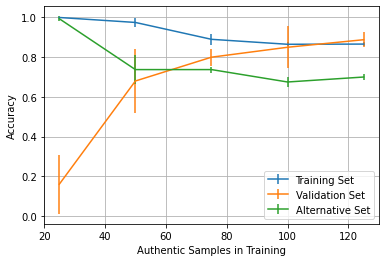

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array w

In [60]:
plt.figure()

plt.errorbar(x=fractions*len(X_tot), y=performance[:,0], yerr=errors[:,0], label='Training Set')
plt.errorbar(x=fractions*len(X_tot), y=performance[:,1], yerr=errors[:,1], label='Validation Set')
plt.errorbar(x=fractions*len(X_tot), y=performance[:,2], yerr=errors[:,2], label='Alternative Set')
plt.grid()
plt.xlabel('Authentic Samples in Training')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [509]:
# The train and test (validation) accuracies converge, and the alternative set has reached a plateau.
# In principle, it seems the model will not benefit from more data.  

# Note that the performance of 70% on the Abroad data is similar to DD-SIMCA with ~60%.
# It seems the non-linearity from this manifold approach only weakly (if at all, statistically speaking)
# improves the predictions. The complexity of the non-linear approach is probably not justified in this 
# case.